# Data Import

In [ ]:
# Mount Google drive to the coding space
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Check if directory exist

!ls "/content/drive/MyDrive/APS360/APS360_Group/"

 data  'Project proposal.gdoc'


In [ ]:
# Import Libraries
import torch
import os
import numpy as np
import pandas as pd

In [ ]:
label_df = pd.read_csv('/content/drive/MyDrive/APS360/APS360_Group/data/unrestricted_5_22_56_15.csv')
#print(label_df.columns)

label_df['Subject'] = label_df['Subject'].astype(str)

trait_columns = ['NEOFAC_A', 'NEOFAC_O', 'NEOFAC_C', 'NEOFAC_N', 'NEOFAC_E']
label_map = {
    row['Subject']: row[trait_columns].values.astype(np.float32)
    for _, row in label_df.iterrows()
}

# Dataset Initialization

In [ ]:
# Dataset Class

from torch.utils.data import Dataset


class fconnDataset(Dataset):
    def __init__(self, root_dir, target_network=None, label_map=None, transform=None):
        """
        Args:
            root_dir (str): Root directory with patient folders.
            target_network (int): Loads a specific network from each patient.
            label_map (dict): Mapping of patient IDs to labels.
            transform (callable): Optional transform to apply to each matrix.
        """
        self.root_dir = root_dir
        self.target_network = target_network
        self.label_map = label_map
        self.transform = transform

        valid_patients = []

        for patient_name in os.listdir(root_dir):
            patient_path = os.path.join(root_dir, patient_name)
            patient_id = os.path.basename(patient_path).replace("subject_", "")
            # Only add patients with network data into valid_patients array
            if os.path.isdir(patient_path) and os.listdir(patient_path):
              label = label_map[patient_id]
              if np.isnan(label).any():
                  continue
              valid_patients.append(patient_path)



        self.valid_patients = valid_patients

    def __len__(self):
        return len(self.valid_patients)

    def __getitem__(self, idx):
        patient_path = self.valid_patients[idx]
        patient_id = os.path.basename(patient_path).replace("subject_", "")

        file_path = os.path.join(patient_path, f"net_{self.target_network:02d}.npy")
        data = np.load(file_path)
        tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(0)  # [1, N, 10]

        if self.transform:
            tensor = self.transform(tensor)

        label_array = self.label_map.get(patient_id, np.full(5, np.nan, dtype=np.float32))
        label_tensor = torch.tensor(label_array, dtype=torch.float32)

        return tensor, label_tensor

    def getpatientid(self, idx):
        patient_path = self.valid_patients[idx]
        patient_id = os.path.basename(patient_path).replace("subject_", "")

        return patient_id

In [ ]:
# Create dataset
# Around 2 min run time

dataset = fconnDataset(root_dir="/content/drive/MyDrive/APS360/APS360_Group/data/output", label_map=label_map,target_network=8)

# Standard 80% training, 10% validation, 10% test dataset
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [ ]:
# Check correlation

X = []
Y = []
for i in range(len(train_dataset)):
    #print(f'{i+1}/{len(train_dataset)}')
    x, y = train_dataset[i]
    X.append(x.reshape(-1).numpy())
    Y.append(y.numpy())

df_X = pd.DataFrame(X)
df_Y = pd.DataFrame(Y, columns=['A', 'O', 'C', 'N', 'E'])

for trait in df_Y.columns:
    correlations = df_X.corrwith(df_Y[trait])
    print(f"{trait} | Top correlations:\n", correlations.abs().sort_values(ascending=False).head(5))

KeyboardInterrupt: 

✅ Best network per trait (based on highest absolute correlation):

- A: Network 06 | Max Correlation: 0.3688
- O: Network 16 | Max Correlation: 0.3800
- C: Network 09 | Max Correlation: 0.4066
- N: Network 03 | Max Correlation: 0.3968
- E: Network 08 | Max Correlation: 0.3878

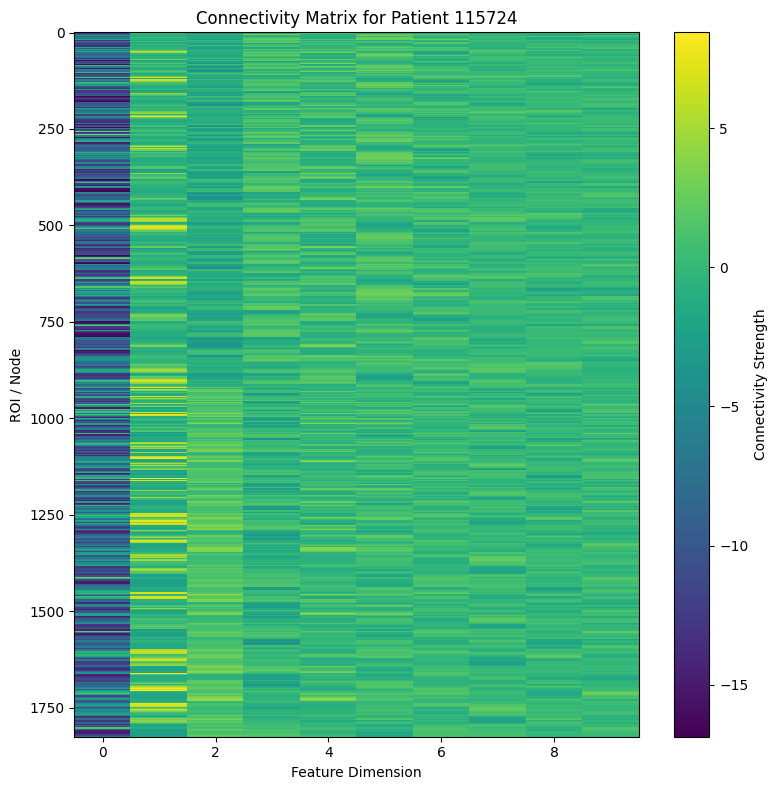

In [ ]:
# Plot to ensure data is correct

import matplotlib.pyplot as plt
# Pick a sample (e.g., the 0th patient)
matrix, tensor = dataset[1]
patient_id = dataset.getpatientid(0)
matrix = matrix.squeeze(0)       # [N, 10]

plt.figure(figsize=(8, 8))
plt.imshow(matrix, cmap='viridis', aspect='auto', interpolation='none')
plt.colorbar(label='Connectivity Strength')
plt.title(f'Connectivity Matrix for Patient {patient_id}')
plt.xlabel("Feature Dimension")
plt.ylabel("ROI / Node")
plt.tight_layout()
plt.show()

# Hyperparameters

In [ ]:
import torch.nn as nn
import torch.optim as optim

batch_size = 32
learning_rate = 1e-3
num_epochs = 30
N = dataset[0][0].shape[1] # Dimension of the Network [1, N, 10], extract region of interest (N)
momentum = 0.9
weight_decay = 1e-3
output_dim = 1

# Data Loader

In [ ]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

Training samples: 871
Validation samples: 108
Test samples: 110


# CNN Model

In [ ]:
import torch.nn as nn

class fconnCNN(nn.Module):
    def __init__(self, N, output_dim):  # N = number of ROIs
        super().__init__()
        self.name = "fconnCNN"

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 3), padding=1),  # [B, 16, N, 10]
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=(2, 2)),                 # [B, 16, N//2, 5]

            nn.Conv2d(16, 32, kernel_size=(3, 3), padding=1), # [B, 32, N//2, 5]
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=(2, 2)),                 # [B, 32, N//4, 2]

            nn.Conv2d(32, 64, kernel_size=(3, 2)),            # [B, 64, N//4 - 2, 1]
            nn.ReLU(),
        )

        # Compute the output shape dynamically
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, N, 10)  # [B=1, C=1, H=N, W=10]
            dummy_output = self.encoder(dummy_input)
            self.flattened_size = dummy_output.view(1, -1).shape[1]

        self.fc = nn.Sequential(
            nn.Linear(self.flattened_size, 128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x.squeeze(1) # Squeeze for 1 trait, don't when computing regression on 5 traits


#Better model
'''
class fconnCNN(nn.Module):
    def __init__(self, N, output_dim):  # N = number of ROIs
        super().__init__()
        self.name = "fconnCNN"

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(16, 32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d((2, 2)),

            nn.Conv2d(32, 64, kernel_size=(3, 2)),
            nn.ReLU(),
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, output_dim)
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.global_pool(x)
        x = self.fc(x)
        return x.squeeze(1) # Squeeze for 1 trait, don't when computing regression on 5 traits
'''

# Baseline Model


In [ ]:
import torch
import torch.nn as nn

class fconnBaseline(nn.Module):
    def __init__(self, N, output_dim):
        super(fconnBaseline, self).__init__()
        input_dim = N * 10  # Flattened [N x 10]

        self.model = nn.Sequential(
            nn.Flatten(),                 # [B, 1, N, 10] → [B, N*10]
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)   # [B, 5]
        )

    def forward(self, x):
        return self.model(x).squeeze(1) # Squeeze for 1 trait, don't when computing regression on 5 traits

# Training Functions

In [ ]:
def evaluate(net, loader, criterion, device, return_r2=False, target_trait=None):
    net.eval()
    total_loss = 0.0
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs, labels = inputs.to(device), labels.to(device)
            if target_trait is not None:
              labels = labels[:,target_trait]
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            all_outputs.append(outputs.cpu())
            all_labels.append(labels.cpu())

    avg_loss = total_loss / (i + 1)

    if return_r2:
        from sklearn.metrics import r2_score
        all_outputs = torch.cat(all_outputs).numpy()
        all_labels = torch.cat(all_labels).numpy()
        r2 = r2_score(all_labels, all_outputs, multioutput='uniform_average')
        return avg_loss, r2

    return avg_loss

def train_model(net, train_loader, val_loader, criterion, optimizer, device, epochs=20, target_trait=None):
    best_val_loss = float('inf')
    best_model_state = None

    # Metric tracking lists
    train_losses = []
    val_losses = []
    val_r2s = []

    for epoch in range(1, epochs + 1):
        net.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            if target_trait is not None:
              labels = labels[:,target_trait]

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss, val_r2 = evaluate(net, val_loader, criterion, device, return_r2=True, target_trait=target_trait)

        # Store metrics
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_r2s.append(val_r2)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = net.state_dict()

        print(f"Epoch {epoch}/{epochs} - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | R²: {val_r2:.4f}")

    # Restore best model
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    # Return model and metrics
    return net, train_losses, val_losses, val_r2s

# Training

In [ ]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Device name: {torch.cuda.get_device_name(0)}")


CNN_model = fconnCNN(N, output_dim).to(device)
baseline_model = fconnBaseline(N, output_dim).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(CNN_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
trait_to_index = {
    "A": 0,  # Agreeableness
    "O": 1,  # Openness
    "C": 2,  # Conscientiousness
    "N": 3,  # Neuroticism
    "E": 4   # Extraversion
}

Using device: cuda
Device name: Tesla T4


In [ ]:
trained_model, train_losses, val_losses, val_r2s = train_model(
    CNN_model, train_loader, val_loader, criterion, optimizer, device, epochs=30, target_trait=trait_to_index["E"]
)

Epoch 1/30 - Train Loss: 595.4678 | Val Loss: 84.7543 | R²: -1.9289
Epoch 2/30 - Train Loss: 67.1887 | Val Loss: 38.2498 | R²: -0.3663
Epoch 3/30 - Train Loss: 52.3832 | Val Loss: 33.3905 | R²: -0.1315
Epoch 4/30 - Train Loss: 51.2234 | Val Loss: 32.5502 | R²: -0.0953
Epoch 5/30 - Train Loss: 49.2697 | Val Loss: 31.5955 | R²: -0.1015
Epoch 6/30 - Train Loss: 51.2103 | Val Loss: 36.8736 | R²: -0.2302
Epoch 7/30 - Train Loss: 54.7891 | Val Loss: 31.9975 | R²: -0.0856
Epoch 8/30 - Train Loss: 51.6150 | Val Loss: 30.9567 | R²: -0.0522
Epoch 9/30 - Train Loss: 48.2269 | Val Loss: 32.8314 | R²: -0.0881
Epoch 10/30 - Train Loss: 49.0917 | Val Loss: 35.3327 | R²: -0.1559
Epoch 11/30 - Train Loss: 45.0942 | Val Loss: 33.4922 | R²: -0.1663
Epoch 12/30 - Train Loss: 53.0698 | Val Loss: 31.1994 | R²: -0.0610
Epoch 13/30 - Train Loss: 48.6071 | Val Loss: 32.9523 | R²: -0.0979
Epoch 14/30 - Train Loss: 45.5324 | Val Loss: 35.1392 | R²: -0.2364
Epoch 15/30 - Train Loss: 50.0767 | Val Loss: 43.7468 | 

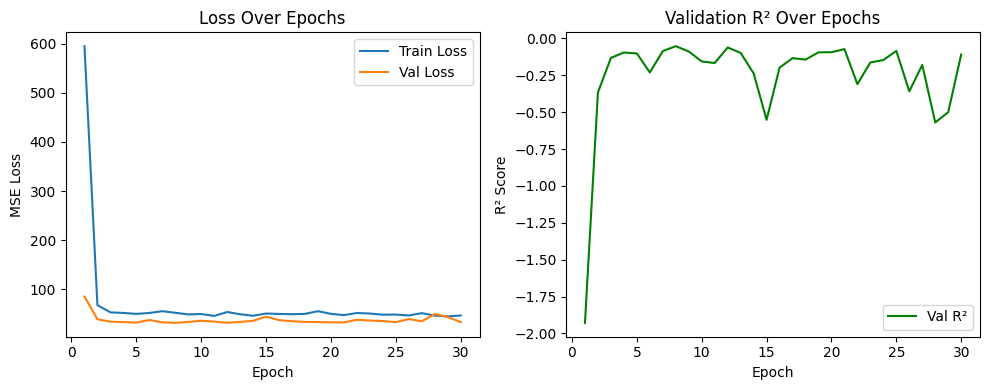

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_r2s, label='Val R²', color='green')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.title('Validation R² Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
'''
import matplotlib.pyplot as plt

preds, labels = [], []
CNN_model.eval()
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        out = CNN_model(x)
        preds.append(out.cpu())
        labels.append(y.cpu())

preds = torch.cat(preds).numpy()
labels = torch.cat(labels).numpy()

for i, trait in enumerate(['A', 'O', 'C', 'N', 'E']):
    plt.scatter(labels[:, i], preds[:, i], alpha=0.5)
    plt.xlabel(f"True {trait}")
    plt.ylabel(f"Predicted {trait}")
    plt.title(f"{trait}: Prediction vs Ground Truth")
    plt.grid(True)
    plt.show()
